## Import Library

In [1]:
# Import required libraries
import os
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from datetime import datetime
from tqdm import tqdm

In [2]:
tqdm.pandas()

## setup spark session

In [3]:
# Setup Spark environment
os.environ["SPARK_HOME"] = "C:\\spark-3.3.2-bin-hadoop3"
os.environ["HADOOP_HOME"] = "C:\\hadoop-3.4.1"
os.environ["JAVA_HOME"] = "C:\\jdk-11.0.26.4-hotspot"
os.environ["PATH"] += f";{os.environ['SPARK_HOME']}\\bin;{os.environ['HADOOP_HOME']}\\bin"

# Create Spark session
spark = SparkSession.builder \
    .master("spark://hadoop-master-node:7077") \
    .appName("SentimentAnalysis") \
    .config("spark.driver.memory", "512M") \
    .config("spark.executor.memory", "512M") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.host", "192.168.1.1") \
    .getOrCreate()

print("✅ Spark Session Created Successfully!")

✅ Spark Session Created Successfully!


## use spark to read from hadoop

In [4]:
# Read preprocessed data from HDFS
df_spark = spark.read.csv("hdfs://hadoop-master-node:9000/sentiment/processed/twitter", 
                         header=True, 
                         inferSchema=True)

In [9]:
df = df_spark.toPandas()
print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Data shape: (50000, 8)

Columns: ['target', 'id', 'date', 'flag', 'user', 'text', 'cleaned_text', 'sentiment']


## Sentiment analysis with pre-train model

In [10]:
# Define sentiment analysis functions
def analyze_sentiment(text):
    """Analyze sentiment using VADER"""
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(str(text))
    return sentiment['compound']


In [11]:

def get_sentiment_label(score):
    """Convert sentiment score to label"""
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'


In [12]:

def textblob_sentiment(text):
    """Analyze sentiment using TextBlob"""
    return TextBlob(str(text)).sentiment.polarity

In [13]:
# Apply VADER sentiment analysis
print("\nApplying VADER sentiment analysis...")
df['vader_score'] = df['cleaned_text'].apply(analyze_sentiment)
df['vader_sentiment'] = df['vader_score'].apply(get_sentiment_label)


Applying VADER sentiment analysis...


In [14]:
# Apply TextBlob sentiment analysis
print("Applying TextBlob sentiment analysis...")
df['textblob_score'] = df['cleaned_text'].apply(textblob_sentiment)
df['textblob_sentiment'] = df['textblob_score'].apply(get_sentiment_label)

Applying TextBlob sentiment analysis...


In [15]:
# Note: Your data has sentiment as -1/1, let's map it to match our labels
df['original_sentiment'] = df['sentiment'].map({-1: 'negative', 1: 'positive'})

In [16]:
vader_accuracy = (df['vader_sentiment'] == df['original_sentiment']).mean() * 100
textblob_accuracy = (df['textblob_sentiment'] == df['original_sentiment']).mean() * 100

In [17]:

print("\nAccuracy Results:")
print(f"VADER Accuracy: {vader_accuracy:.2f}%")
print(f"TextBlob Accuracy: {textblob_accuracy:.2f}%")


Accuracy Results:
VADER Accuracy: 44.11%
TextBlob Accuracy: 33.47%


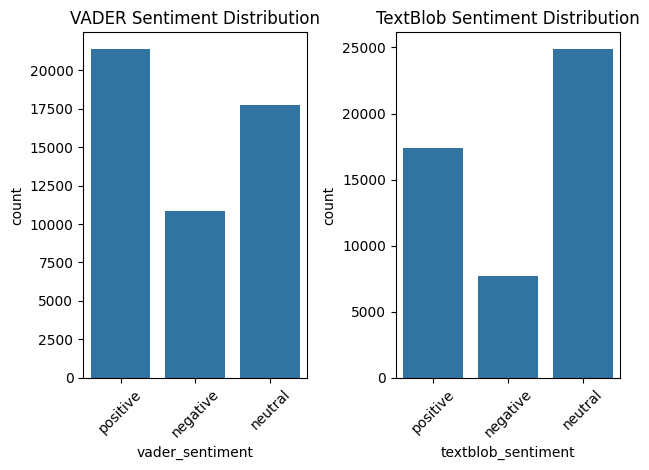

In [18]:
# VADER Distribution
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='vader_sentiment')
plt.title('VADER Sentiment Distribution')
plt.xticks(rotation=45)

# TextBlob Distribution
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='textblob_sentiment')
plt.title('TextBlob Sentiment Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
df

,target,id,date,flag,user,text,cleaned_text,sentiment,vader_score,vader_sentiment,textblob_score,textblob_sentiment,original_sentiment
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok,-1,0.6249,positive,0.50000,positive,negative
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",cool tweet app razr,-1,0.3182,positive,0.35000,positive,negative
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,know famili drama lamehey next time u hang kim...,-1,-0.0772,negative,-0.25000,negative,negative
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email wont open geographi stuff revis s...,-1,-0.5267,negative,-0.40000,negative,negative
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airway problem,-1,-0.4019,negative,0.00000,neutral,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4,1994250075,Mon Jun 01 11:38:47 PDT 2009,NO_QUERY,pauliinhawinter,@LucasCruikshank you have talent. that's why p...,talent that peopl jealou support fred love fred,1,0.8658,positive,0.50000,positive,positive
49996,0,2230625674,Thu Jun 18 17:22:40 PDT 2009,NO_QUERY,J1437,frustrated,frustrat,-1,0.0000,neutral,0.00000,neutral,negative
49997,0,2183723317,Mon Jun 15 14:53:56 PDT 2009,NO_QUERY,brennao,@DataVonTeese Ow fuck!! Tinfoil cuts are horri...,ow fuck tinfoil cut horribl,-1,-0.6808,negative,-0.40000,negative,negative
49998,0,2229474147,Thu Jun 18 15:46:36 PDT 2009,NO_QUERY,vitorious,&quot;lol Vito. Quite the lala land you're in....,quotlol vito quit lala land your inquot guess ...,-1,0.0000,neutral,-0.15625,negative,negative


## Save the analyze data back to hadoop using spark

In [ ]:
# Save results back to HDFS
print("\nSaving results back to HDFS...")
result_spark_df = spark.createDataFrame(df)
result_spark_df.write.mode('overwrite').parquet("hdfs://hadoop-master-node:9000/sentiment/results/twitter")
print("✅ Results saved successfully!")

# Display some example results
print("\nExample Results:")
sample_results = df[['cleaned_text', 'original_sentiment', 'vader_sentiment', 'textblob_sentiment']].head()
sample_results


Saving results back to HDFS...


d:\Download\Anaconda\anaconda3\envs\sentiment-analysis-env\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
d:\Download\Anaconda\anaconda3\envs\sentiment-analysis-env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


✅ Results saved successfully!

Example Results:
                                        cleaned_text original_sentiment  \
0                                       ahhh hope ok           negative   
1                                cool tweet app razr           negative   
2  know famili drama lamehey next time u hang kim...           negative   
3  school email wont open geographi stuff revis s...           negative   
4                               upper airway problem           negative   

  vader_sentiment textblob_sentiment  
0        positive           positive  
1        positive           positive  
2        negative           negative  
3        negative           negative  
4        negative            neutral  
